In [1]:
import numpy as np
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.image as mpimg
from nltk.corpus import wordnet as wn
nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}
from sklearn.metrics.pairwise import euclidean_distances
import csv
from sklearn import preprocessing

/Users/yingzhu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read data function
def read_descriptions_train():
    descriptions_train_path = '/Users/yingzhu/Desktop/data/descriptions_train/'
    sample_description = []
    for i in range(10000):
        file_name = str(i) + '.txt'
        file_path = descriptions_train_path + file_name
        descriptions = []
        with open(file_path) as f:
            for line in f.readlines():
                descriptions.append(line.strip('\n'))
        sample_description.append(descriptions)
    return sample_description

def read_descriptions_test():
    descriptions_test_path = '/Users/yingzhu/Desktop/data/descriptions_test/'
    sample_description = []
    for i in range(2000):
        file_name = str(i) + '.txt'
        file_path = descriptions_test_path + file_name
        descriptions = []
        with open(file_path) as f:
            for line in f.readlines():
                descriptions.append(line.strip('\n'))
        sample_description.append(descriptions)
    return sample_description

def read_tags_train():
    tags_train_path = '/Users/yingzhu/Desktop/data/tags_train/'
    sample_tag = []
    for i in range(10000):
        file_name = str(i) + '.txt'
        file_path = tags_train_path + file_name
        tags = {}
        with open(file_path) as f:
            for line in f.readlines():
                key, value = line.strip('\n').split(':')
                if tags.get(key) == None:
                    tags[key] = [value]
                else:
                    tags[key].append(value)
        sample_tag.append(tags)
    return sample_tag

def read_tags_test():
    tags_test_path = '/Users/yingzhu/Desktop/data/tags_test/'
    sample_tag = []
    for i in range(2000):
        file_name = str(i) + '.txt'
        file_path = tags_test_path + file_name
        tags = {}
        with open(file_path) as f:
            for line in f.readlines():
                key, value = line.strip('\n').split(':')
                if tags.get(key) == None:
                    tags[key] = [value]
                else:
                    tags[key].append(value)
        sample_tag.append(tags)
    return sample_tag

In [3]:
def pre_process_noun(description_file):
    stopwords = nltk.corpus.stopwords.words('english')
    stemmer = nltk.SnowballStemmer("english")
    words_dict=set()
    for descriptions in description_file:
        for i in range(len(descriptions)):
            lowered = descriptions[i].lower()
            word_list = re.findall(r"[a-z]+", lowered)
            filtered_words = [stemmer.stem(word) for word in word_list if (word not in stopwords and word in nouns)]
            words_dict.update(set(filtered_words))
            descriptions[i] = filtered_words
    return words_dict

In [268]:
# data processing
def pre_processing(descriptions_file):
    stopwords = nltk.corpus.stopwords.words('english')
    stemmer = nltk.SnowballStemmer("english")
    words = set()
    for descriptions in descriptions_file:
        for i in range(len(descriptions)):
            lowered = descriptions[i].lower()
            word_list = re.findall(r"[a-z]+", lowered)
            filtered_words = [stemmer.stem(word) for word in word_list if word not in stopwords]
            words.update(set(filtered_words))
            descriptions[i] = filtered_words
    words = list(words)
    BoW_data = []
    for descriptions in descriptions_file:
        bag = [0 for _ in range(len(words))]
        for description in descriptions:
            for word in description:    
                if word in words: bag[words.index(word)] += 1
        BoW_data.append(bag)
    return BoW_data, words

In [3]:
def pre_process(description_file):
    stopwords = nltk.corpus.stopwords.words('english')
    stemmer = nltk.SnowballStemmer("english")
    words_dict=set()
    for descriptions in description_file:
        for i in range(len(descriptions)):
            lowered = descriptions[i].lower()
            word_list = re.findall(r"[a-z]+", lowered)
            filtered_words = [stemmer.stem(word) for word in word_list if word not in stopwords]
            words_dict.update(set(filtered_words))
            descriptions[i] = filtered_words
    return words_dict

In [4]:
def pre_proc(description_file,words_dict_total):
    bag = []
    for description in description_file:
        bow_data = [0]*len(words_dict_total)
        for i in range(len(description)):
            for word in description[i]:
                if word in words_dict_total: bow_data[words_dict_total.index(word)] += 1
        bag.append(bow_data)
    return bag

In [206]:
def pre_proc_tag(tag_train,tag_dict):
    bag = []
    for tag_list in tag_train:
        bow_data = [0]*len(tag_dict)
        for tag in tag_list:
            if tag in tag_dict: bow_data[tag_dict.index(tag)] += 1
        bag.append(bow_data)
    return bag

In [207]:
def stem_tag(tag_train):
    stemmer = nltk.SnowballStemmer("english")
    new_tag_train =[]
    for tag_list in tag_train:
        lowered = [tag.lower() for tag in tag_list]
        filtered_words = [stemmer.stem(tag) for tag in lowered]
        new_tag_train.append(filtered_words)
    return new_tag_train

In [5]:
# read file 
train_description, test_description = read_descriptions_train(), read_descriptions_test()
tags_train, tags_test = read_tags_train(), read_tags_test()

In [13]:
train_description_noun,test_description_noun = read_descriptions_train(), read_descriptions_test()

In [103]:
train_description[0]

['The skateboarder is putting on a show using the picnic table as his stage.',
 'A skateboarder pulling tricks on top of a picnic table.',
 'A man riding on a skateboard on top of a table.',
 'A skate boarder doing a trick on a picnic table.',
 'A person is riding a skateboard on a picnic table with a crowd watching.']

In [6]:
# get description word dictionary
#description_train,words_dict = pre_processing(train_description)
words_dict = pre_process(train_description)
words_dict2 = pre_process(test_description)

# process the description test
words_dict_total = list(set(words_dict) | set(words_dict2))
description_test = pre_proc(test_description,words_dict_total)
description_train = pre_proc(train_description,words_dict_total)

In [97]:
words_dict_total[:10]

['calendar',
 'undecor',
 'windsail',
 'pathway',
 'shoulder',
 'fog',
 'parasail',
 'ltd',
 'station',
 'ne']

In [14]:
# get description word (noun) dictionary
#description_train,words_dict = pre_processing(train_description)
words_dict_noun = pre_process_noun(train_description_noun)
words_dict2_noun = pre_process_noun(test_description_noun)

# process the description test(noun)
words_dict_total_noun = list(set(words_dict_noun) | set(words_dict2_noun))
description_test_noun = pre_proc(test_description,words_dict_total_noun)
description_train_noun = pre_proc(train_description,words_dict_total_noun)

In [7]:
# function to read features 
def read_features_train_1000():
    file_path = '/Users/yingzhu/Desktop/data/features_train/features_resnet1000_train.csv'
    descriptions_1000 = [0 for _ in range(10000)]
    with open(file_path) as f:
        for line in f.readlines():
            vector = line.strip('\n').split(',')
            image_index = int(vector[0].split('/')[1].split('.')[0])
            descriptions_1000[image_index] = [float(i) for i in vector[1:]]
    return descriptions_1000

def read_features_train_2048():
    file_path = '/Users/yingzhu/Desktop/data/features_train/features_resnet1000intermediate_train.csv'
    descriptions_2048 = [0 for _ in range(10000)]
    with open(file_path) as f:
        for line in f.readlines():
            vector = line.strip('\n').split(',')
            image_index = int(vector[0].split('/')[1].split('.')[0])
            descriptions_2048[image_index] = [float(i) for i in vector[1:]]
    return descriptions_2048

def read_features_test_1000():
    file_path = '/Users/yingzhu/Desktop/data/features_test/features_resnet1000_test.csv'
    descriptions_1000 = [0 for _ in range(2000)]
    with open(file_path) as f:
        for line in f.readlines():
            vector = line.strip('\n').split(',')
            image_index = int(vector[0].split('/')[1].split('.')[0])
            descriptions_1000[image_index] = [float(i) for i in vector[1:]]
    return descriptions_1000

def read_features_test_2048():
    file_path = '/Users/yingzhu/Desktop/data/features_test/features_resnet1000intermediate_test.csv'
    descriptions_2048 = [0 for _ in range(2000)]
    with open(file_path) as f:
        for line in f.readlines():
            vector = line.strip('\n').split(',')
            image_index = int(vector[0].split('/')[1].split('.')[0])
            descriptions_2048[image_index] = [float(i) for i in vector[1:]]
    return descriptions_2048

In [8]:
features_train_1000, features_train_2048 = read_features_train_1000(),read_features_train_2048()
features_test_1000, features_test_2048 = read_features_test_1000(),read_features_test_2048()

In [159]:
############################## MLP for Cross Validation ###################################
def run_mlp(features_train,description_train,mlr):
    indices = np.arange(len(features_train))
    x_train, x_test, y_train, y_test,idx1, idx2 = \
    train_test_split(np.array(features_train), np.array(description_train),indices,test_size=0.2, random_state=15)
    mlr.fit(x_train, y_train)
    return x_train, x_test, y_train, y_test,idx1, idx2

In [9]:
############################ MLP for real test data #####################################
def run_mlp_true(features_train,description_train,mlr):
    mlr.fit(features_train,description_train)

In [10]:
# function to find the top 20 graphs
def find_top20(y_predict,y_test,index):
    graph_rank =[]
    rank = -cosine_similarity(y_test,y_predict)
    for i in range(len(rank)):
        index_rank = rank[i].argsort()[:20]
        graph_rank.append([index[k] for k in index_rank])
    return graph_rank

def find_top20_test(y_predict,y_test):
    graph_rank=[]
    score_rank = cosine_similarity(y_test,y_predict)
    rank = [-i for i in score_rank]
    for i in range(len(rank)):
        index_rank = rank[i].argsort()[:20]
        graph_rank.append(index_rank)
    return graph_rank,score_rank

def find_top(y_predict,y_test,index):
    graph_rank = []
    for i in range(len(y_test)):
        graph_score = (-np.dot(y_predict,y_test[i])).argsort()[:20]
        graph_rank.append([index[k] for k in graph_score])
    return graph_rank

In [55]:
def find_top20_test2(y_predict,y_test):
    graph_rank=[]
    for i in range(len(y_test)):
        rank = -np.dot(y_predict,y_test[i])
        index_rank = rank.argsort()[:20]
        graph_rank.append(index_rank)
    return graph_rank

In [240]:
# function convert the result we get from neural network into 0/1 vector
def convert_res(y_predict):
    convert_res=[]
    for i in range(len(y_predict)):
        convert_temp = [0]*len(y_predict[i])
        index_rank = (-y_predict[i]).argsort()[:10]   ## top 20 words assosciated with each graph
        convert_temp=[1 if i in index_rank else e for i,e in enumerate(convert_temp)]
        convert_res.append(convert_temp)
    return convert_res

In [241]:
# function add the effect of tag into result
def add_tag_test(y_predict,tag_add):
    true_predict =[]
    for i in range(len(y_predict)):
        true_predict.append(y_predict[i]+tag_add[i])
    return true_predict

In [242]:
# function to calculate score sccording to MAP 20, rank_res is the the final result of graph index
def scoring(rank_res,target_index):
    score =0
    for i in range(len(rank_res)):
        if(rank_res[i]==target_index):
            score = (20-i)/20
    return score

In [243]:
def test_score(y_predict,y_test,idx2,function_index):
    total_score=[]
    if function_index==20:
        graph_rank = find_top20(y_predict,y_test,idx2)
    else:
        graph_rank = find_top(y_predict,y_test,idx2)
    for i in range(len(idx2)):
        total_score.append(scoring(graph_rank[i],idx2[i]))
    return total_score,graph_rank

In [84]:
# output true test result
mlr3 = MLP(hidden_layer_sizes=(600,))
run_mlp_true(features_train_2048,description_train,mlr3)

In [85]:
# prediction
true_predict = mlr3.predict(features_test_2048)

In [86]:
true_predict = add_tag_test(true_predict,np.array(tag_test_dictv))
true_predict = convert_res(true_predict)

In [87]:
graph_rank = find_top20_test(true_predict,description_test)

['A woman unpacks a box in a kitchen. ', 'Woman in red shirt standing in a kitchen.', 'View through an archway of a kitchen and a lady working by the window.', 'A woman in a red shirt in the kitchen of a house with ceiling fan light on in the room.', 'A woman stands in the kitchen with a vest draped over a chair.']
0


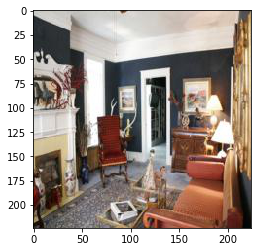

1


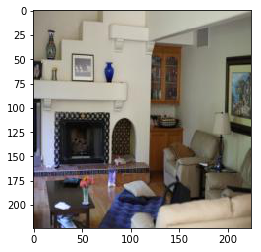

2


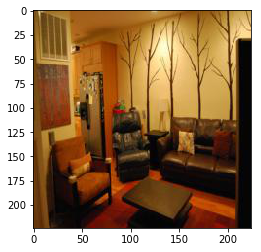

3


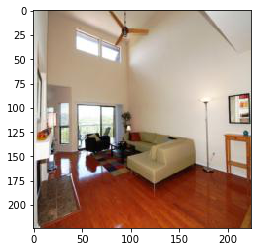

4


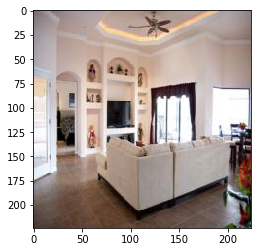

5


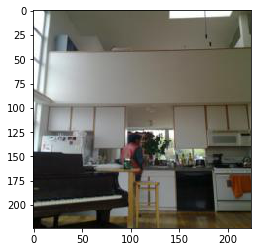

6


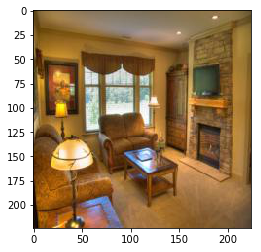

7


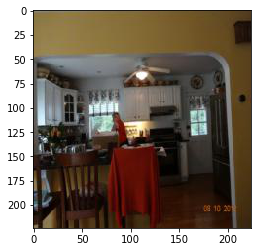

8


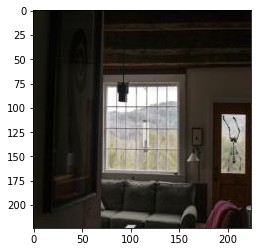

9


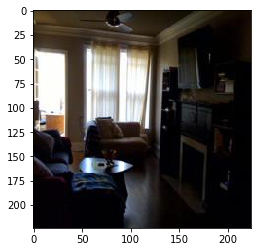

10


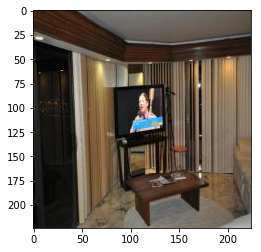

11


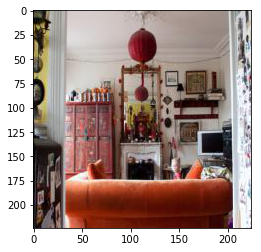

12


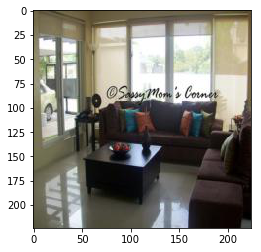

13


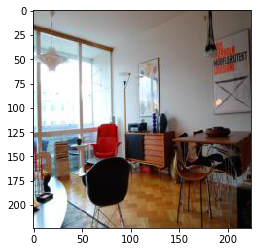

14


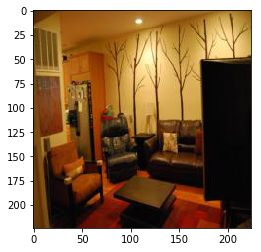

15


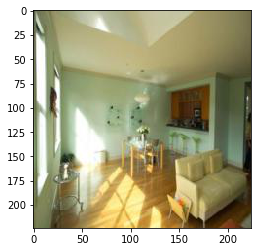

16


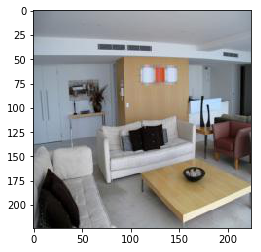

17


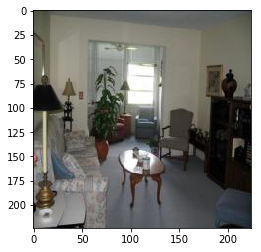

18


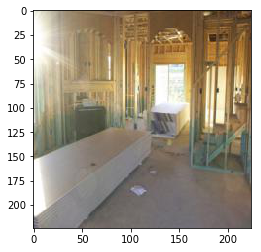

19


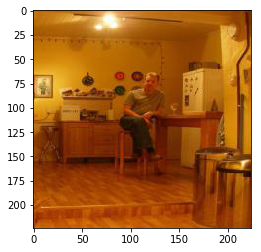

In [212]:
display_graph(graph_rank,test_description,137)

In [845]:
'street' in words_dict_total 

True

In [11]:
def display_graph(graph_rank,test_description,num):
    print(test_description[num])
    for i in range(len(graph_rank[num])):
        print(i)
        path = '/Users/yingzhu/Desktop/data/images_test/'+str(graph_rank[num][i])+'.jpg'
        img = mpimg.imread(path)
        implot = plt.imshow(img)
        plt.show()

In [29]:
def display_graph_validation(graph_rank,train_description,index, num):
    print(train_description[index[num]])
    for i in range(len(graph_rank[num])):
        print(i)
        path = '/Users/yingzhu/Desktop/data/images_train/'+str(graph_rank[num][i])+'.jpg'
        img = mpimg.imread(path)
        implot = plt.imshow(img)
        plt.show()

In [275]:
# neural network that map description to features (features_2048)
mlr4 = MLP(hidden_layer_sizes=(1500,))
run_mlp_true(description_train,features_train_2048,mlr4)

In [163]:
true_predict = mlr4.predict(description_test)

In [46]:
# function to find the cloest graph according to the prediction made by neural network
def top20(test_graph_features,true_prediction):
    graph_rank =[]
    for i in range(len(true_prediction)):
        dist = euclidean_distances(test_graph_features,true_prediction[i])
        temp_rank = dist.argsort()[:20]
        graph_rank.append(temp_rank)
    return graph_rank

In [164]:
graph_rank,score_rank =find_top20_test(features_test_2048,true_predict)

[['pizza', 'sit', 'top', 'wooden', 'cut', 'board'], ['pizza', 'load', 'melt', 'chees', 'veget', 'green', 'pepper'], ['pizza', 'bell', 'pepper', 'meat', 'sauc'], ['veget', 'pizza', 'slice', 'piec'], ['pizza', 'pizza', 'cutter', 'green', 'pepper', 'top']]
0


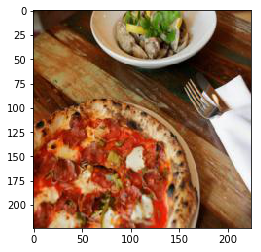

1


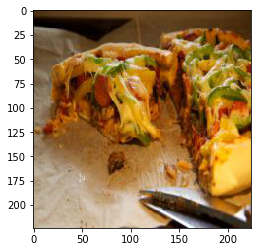

2


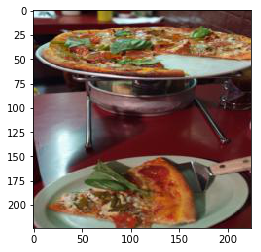

3


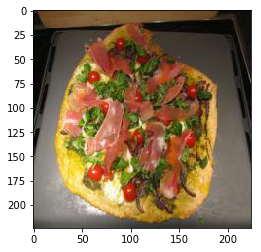

4


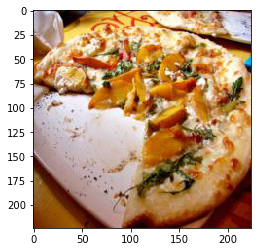

5


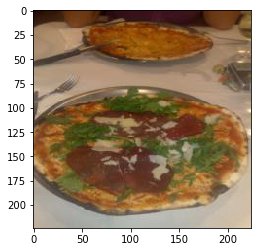

6


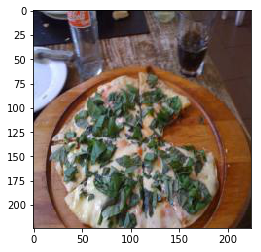

7


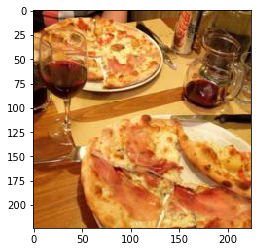

8


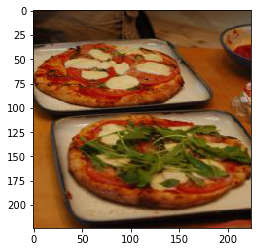

9


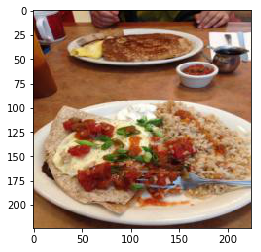

10


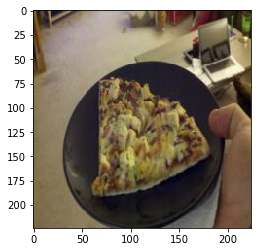

11


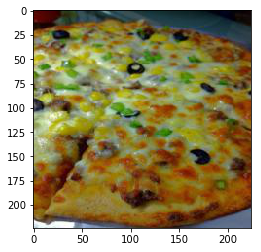

12


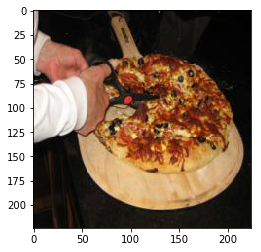

13


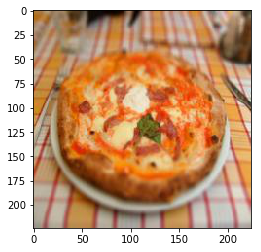

14


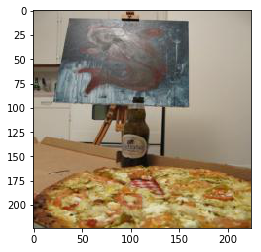

15


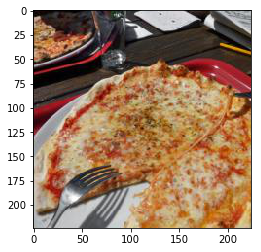

16


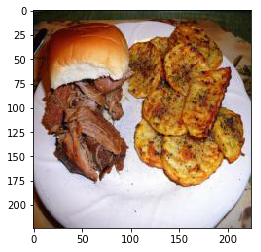

17


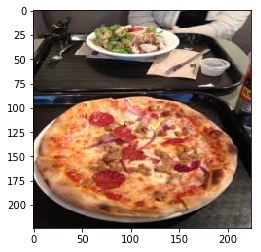

18


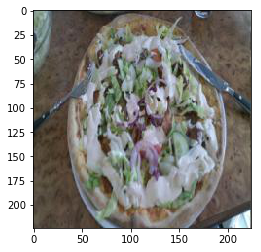

19


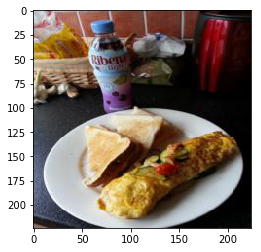

In [264]:
display_graph(graph_rank,test_description,15)

In [126]:
# write out function
with open('/Users/yingzhu/Desktop/prediction9_1000layer.csv','w') as f:
    f.write('Descritpion_ID,Top_20_Image_IDs\n')
    for i in range(2000):
        st = graph_rank[i]
        prediction = ' '.join([str(j) + '.jpg' for j in st])
        write = str(i) + '.txt,'  + prediction
        f.write(write+'\n')    
    f.close()

In [168]:
# write the result to csv file for future use
with open('/Users/yingzhu/Desktop/score_from_neural_1.csv','w') as f:
    for i in range(len(score_rank)):
        st = score_rank[i]
        write = ','.join([str(j) for j in st])
        f.write(write+'\n')
    f.close()

In [120]:
# test the csv reading
with open('/Users/yingzhu/Desktop/score_from_neural1.csv') as f:
    descriptions=[]
    for line in f.readlines():
        descriptions.append([float(num) for num in line.strip('\n').split(',')])

(2000, 2000)

In [12]:
# neural network that map description to features(features_1000)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [13]:
scaler.fit(features_train_1000)
features_test_1000 = scaler.transform(features_test_1000)
features_train_1000 = scaler.transform(features_train_1000)

In [15]:
mlr5 = MLP(hidden_layer_sizes=(1000,))
run_mlp_true(description_train,features_train_1000,mlr5)

In [16]:
true_predict1 = mlr5.predict(description_test)

In [17]:
graph_rank1,score_rank1 =find_top20_test(features_test_1000,true_predict1)

[['pizza', 'sit', 'top', 'wooden', 'cut', 'board'], ['pizza', 'load', 'melt', 'chees', 'veget', 'green', 'pepper'], ['pizza', 'bell', 'pepper', 'meat', 'sauc'], ['veget', 'pizza', 'slice', 'piec'], ['pizza', 'pizza', 'cutter', 'green', 'pepper', 'top']]
0


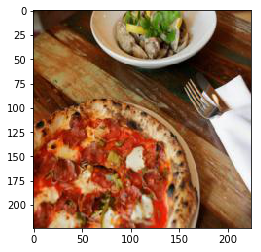

1


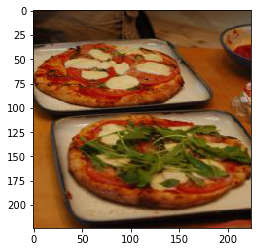

2


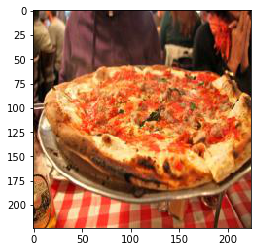

3


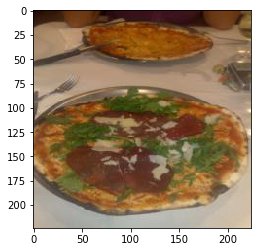

4


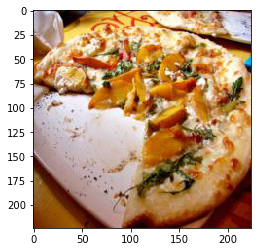

5


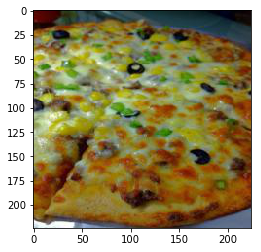

6


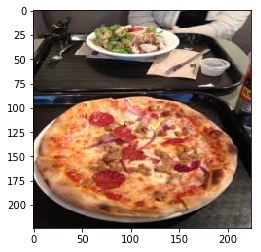

7


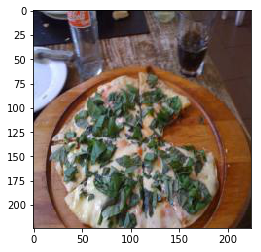

8


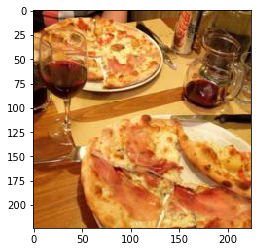

9


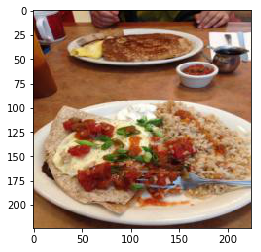

10


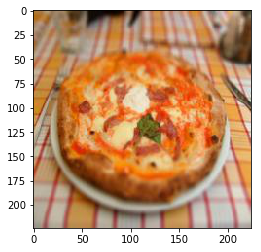

11


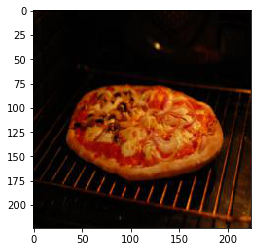

12


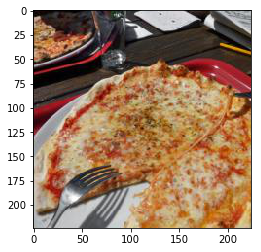

13


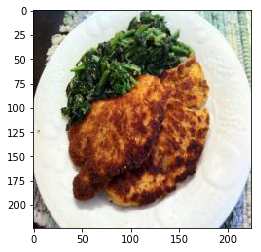

14


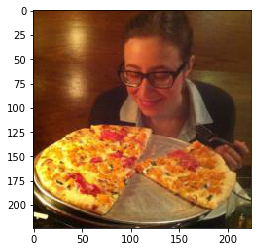

15


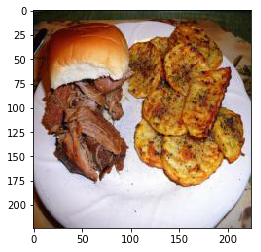

16


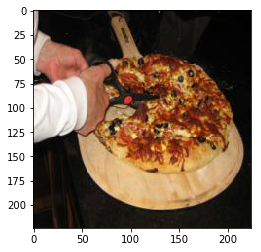

17


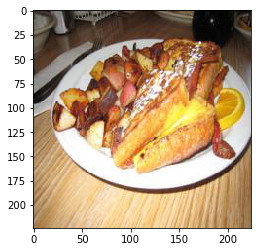

18


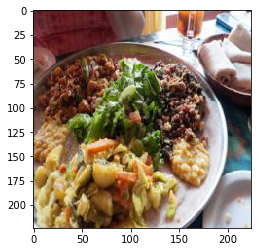

19


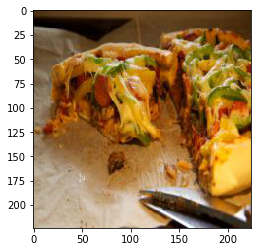

In [19]:
display_graph(graph_rank1,test_description,15)

In [21]:
# write out function
with open('/Users/yingzhu/Desktop/prediction9_600layer.csv','w') as f:
    f.write('Descritpion_ID,Top_20_Image_IDs\n')
    for i in range(2000):
        st = graph_rank1[i]
        prediction = ' '.join([str(j) + '.jpg' for j in st])
        write = str(i) + '.txt,'  + prediction
        f.write(write+'\n')    
    f.close()

In [20]:
# write the result to csv file for future use
with open('/Users/yingzhu/Desktop/score_from_neural_noun1.csv','w') as f:
    for i in range(len(score_rank1)):
        st = score_rank1[i]
        write = ','.join([str(j) for j in st])
        f.write(write+'\n')
    f.close()